# Two MultiTLE instances
This notebook will implement loading two MultiTLE instances and propogating them across a range of datateimes to identify intersections at common times.

In [1]:
from skyfield.api import load, Timescale, wgs84
from ssncs.multi_tle import MultiTLE
from ssncs.path_segment import PathSegment
from ssncs.ring import FIFORingBuffer as RingBuffer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import cartopy.crs as ccrs
import cmcrameri.cm as cm

In [3]:
tau = dt.timedelta(minutes=20)
freq = dt.timedelta(seconds=30)

In [4]:
ts = load.timescale()
ts

In [5]:
icesat = MultiTLE.from_json_file("../data/icesat2_test.json", ts=ts)
earthcare = MultiTLE.from_json_file("../data/earthcare_test.json", ts=ts)
icesat, earthcare

(<ssncs.multi_tle.MultiTLE at 0x1304f4bf0>,
 <ssncs.multi_tle.MultiTLE at 0x13158adb0>)

In [6]:
icesat.epochs, earthcare.epochs

(array([datetime.datetime(2024, 5, 28, 13, 7, 41, 460960, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 28, 20, 58, 51, 571200, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 29, 14, 15, 25, 246944, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 29, 20, 32, 20, 929056, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 29, 22, 6, 34, 831872, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 30, 13, 48, 53, 461728, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 30, 21, 40, 2, 469504, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 31, 3, 56, 57, 544224, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 5, 31, 13, 22, 19, 831008, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 6, 1, 1, 56, 22, 801344, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 6, 1, 11, 22, 7, 975488, tzinfo=datetime.timezone.utc),
        datetime.d

In [7]:
datetimes = pd.date_range(
    start=np.min([icesat.epochs[0],earthcare.epochs[0]]),
    end=np.max([icesat.epochs[-1], earthcare.epochs[-1]]),
    freq=freq,
    tz=dt.timezone.utc,
).to_pydatetime()
datetimes

array([datetime.datetime(2024, 5, 28, 13, 7, 41, 460960, tzinfo=datetime.timezone.utc),
       datetime.datetime(2024, 5, 28, 13, 8, 11, 460960, tzinfo=datetime.timezone.utc),
       datetime.datetime(2024, 5, 28, 13, 8, 41, 460960, tzinfo=datetime.timezone.utc),
       ...,
       datetime.datetime(2024, 6, 4, 8, 12, 41, 460960, tzinfo=datetime.timezone.utc),
       datetime.datetime(2024, 6, 4, 8, 13, 11, 460960, tzinfo=datetime.timezone.utc),
       datetime.datetime(2024, 6, 4, 8, 13, 41, 460960, tzinfo=datetime.timezone.utc)],
      shape=(19573,), dtype=object)

In [8]:
icesat_lon_lat = icesat.get_lon_lat_at_datetimes(
    datetimes=datetimes,
    ts=ts
)
earthcare_lon_lat = earthcare.get_lon_lat_at_datetimes(
    datetimes=datetimes,
    ts=ts
)

In [9]:
satslice = slice(0,100)

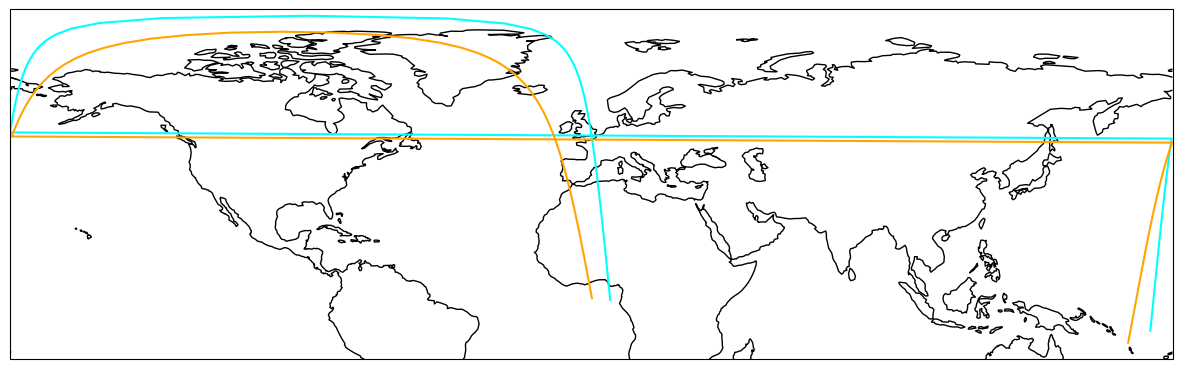

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,8), subplot_kw=dict(projection=ccrs.PlateCarree()))

#ax.scatter(lon_slice, lat_slice, s=10)
ax.plot(
    icesat_lon_lat[0][satslice],
    icesat_lon_lat[1][satslice],
    c="cyan"
)
ax.plot(
    earthcare_lon_lat[0][satslice],
    earthcare_lon_lat[1][satslice],
    c="orange"
)
ax.coastlines()

plt.show()

In [11]:
xy1 = np.stack(icesat_lon_lat, axis=1)
xy2 = np.stack(earthcare_lon_lat, axis=1)

In [12]:
xy1.shape == xy2.shape

True

In [13]:

N_halfwidth = int(tau/freq) + 1
N = 2*N_halfwidth + 1

In [14]:
plate_carree = ccrs.PlateCarree()

In [15]:
ring = RingBuffer(capacity=N-1)

In [16]:
ring.push(*[
    PathSegment(
        start=xy21,
        end = xy22,
        crs = plate_carree
    )
    for xy21, xy22 in zip(xy2[:N-1,:], xy2[1:N,:])
])

In [17]:
xy2 = xy2[N-1:,:]
xy21 = xy2[0,:]
xy22 = xy2[1,:]
xy1 = xy1[N_halfwidth-1:-N_halfwidth]
xy1.shape, xy2.shape

((19492, 2), (19491, 2))

In [18]:
intersection_indices = list()
for i, (xy11, next_xy2, dtime) in enumerate(zip(xy1,xy2, datetimes[N_halfwidth: -N_halfwidth] )):
    xy12 = xy1[i+1, :]
    ps1 = PathSegment(start=xy11, end=xy12, crs=plate_carree)

    # transform elements of ring-buffer into tangent plane at ps1.start
    crs_ps1 = ccrs.AzimuthalEquidistant(central_longitude=ps1.start[0], central_latitude=ps1.start[1])
    transformed_buffer = [
        ps2.transform_crs(crs_ps1) for ps2 in ring.see()
    ]
    ps1_transformed = ps1.transform_crs(crs_ps1)

    if True in [ps1_transformed.intersects(ps2) for ps2 in transformed_buffer]:
        print(f"Intersection!!!!!! {i=}, {dtime=}")
        intersection_indices.append(i)
    
    xy21 = xy22
    xy22 = next_xy2

Intersection!!!!!! i=29, dtime=datetime.datetime(2024, 5, 28, 13, 42, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=187, dtime=datetime.datetime(2024, 5, 28, 15, 1, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=379, dtime=datetime.datetime(2024, 5, 28, 16, 37, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=577, dtime=datetime.datetime(2024, 5, 28, 18, 16, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=765, dtime=datetime.datetime(2024, 5, 28, 19, 50, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=953, dtime=datetime.datetime(2024, 5, 28, 21, 24, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=1143, dtime=datetime.datetime(2024, 5, 28, 22, 59, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=1339, dtime=datetime.datetime(2024, 5, 29, 0, 37, 41, 460960, tzinfo=datetime.timezone.utc)
Intersection!!!!!! i=1503, dtime=datetime.datetime(2024, 5, 29, 1, 59, 41, 460960, tzinfo=datetim

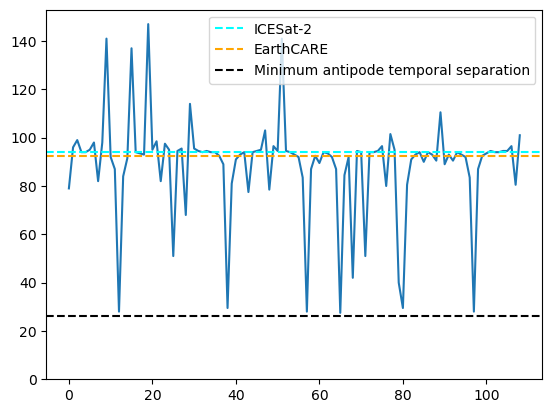

In [19]:
time_between_intersections = np.diff(intersection_indices) * freq

period_icesat = 2 * np.pi / icesat.tles[0].model.no_kozai
period_earthcare = 2 * np.pi / earthcare.tles[0].model.no_kozai

plt.plot([t/dt.timedelta(minutes=1) for t in time_between_intersections])
plt.axhline(
    period_icesat, ls= "--", c="cyan", label="ICESat-2"
)
plt.axhline(
    period_earthcare, ls= "--", c="orange", label="EarthCARE"
)
plt.axhline(
    np.min([period_icesat,period_earthcare])/2 - tau.seconds/60, ls= "--", c="black", label="Minimum antipode temporal separation"
)
plt.gca().set_ylim([0,None])
plt.legend()
plt.show()

In [20]:
tau.seconds/60

20.0

In [21]:
(
    2* np.pi / icesat.tles[0].model.no_kozai,
    2* np.pi / earthcare.tles[0].model.no_kozai,
)

(94.16824796680731, 92.58753349831427)

In [22]:
def mean_spherical_pos(lons, lats):
    cosdeg = lambda x: np.cos(np.deg2rad(x))
    sindeg = lambda x: np.sin(np.deg2rad(x))
    x = np.mean(cosdeg(lons)*cosdeg(lats))
    y = np.mean(sindeg(lons)*cosdeg(lats))
    z = np.mean(sindeg(lats))
    lon = np.rad2deg(np.arctan2(x,y))
    lat = np.rad2deg(np.arcsin(z))
    return lon, lat

In [24]:
len(intersection_indices)

110

(np.float64(179.17271766896502), np.float64(46.15292591155212))


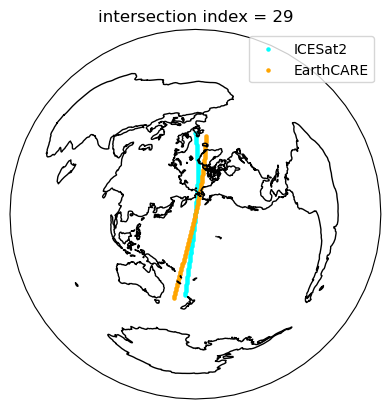

(np.float64(-30.446131343911045), np.float64(75.55977026015087))


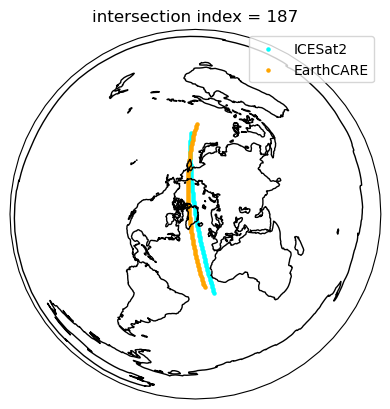

(np.float64(-61.37053852980483), np.float64(82.16725754462456))


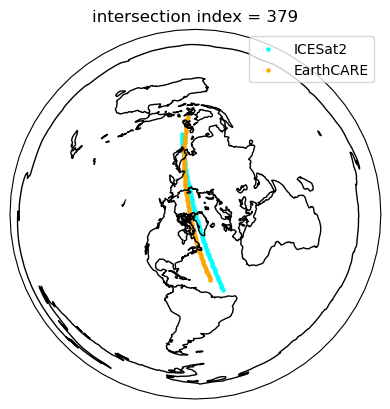

(np.float64(-68.1679464079497), np.float64(80.60214136032982))


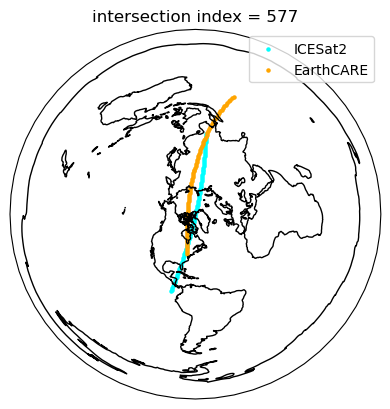

(np.float64(-90.44481996593376), np.float64(81.46588201153439))


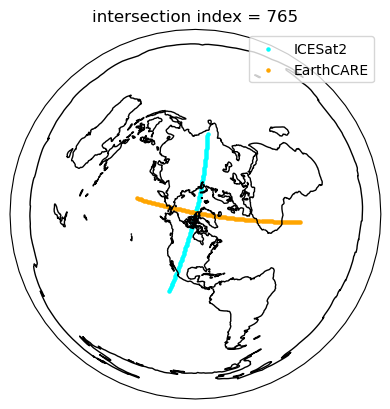

(np.float64(-112.43993762750488), np.float64(82.32409929826791))


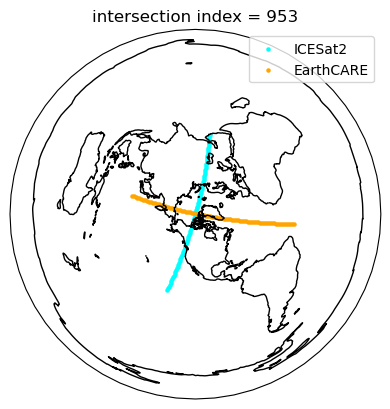

(np.float64(-140.4010362845411), np.float64(79.47243907082625))


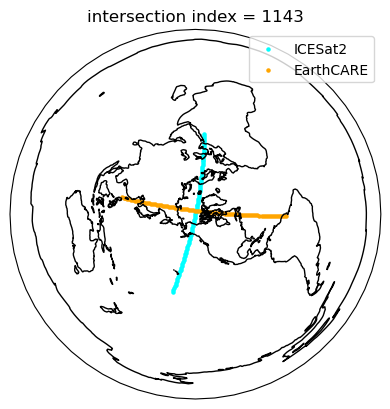

(np.float64(-171.41026686923558), np.float64(65.21613551504748))


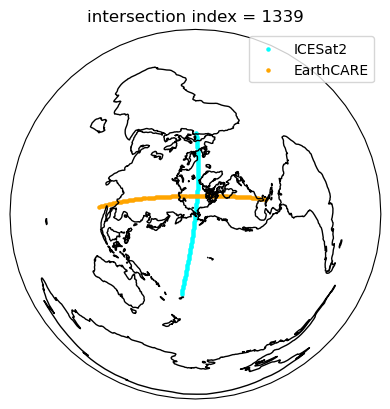

(np.float64(-21.20221443971126), np.float64(68.0066561227958))


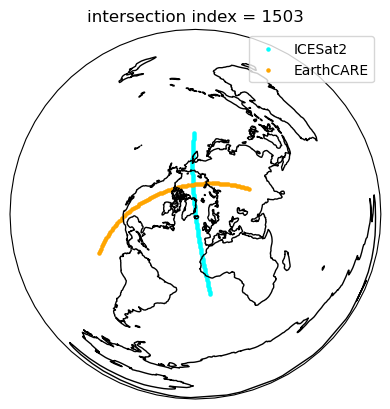

(np.float64(-55.49972917604353), np.float64(82.19481587456204))


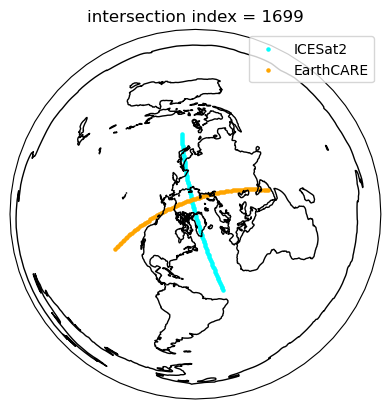

(np.float64(-147.25967644431387), np.float64(80.61237401363572))


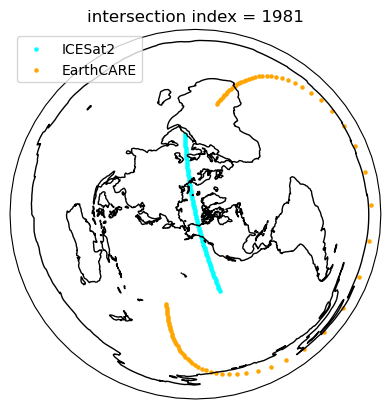

(np.float64(-164.39126517180125), np.float64(72.21332639951353))


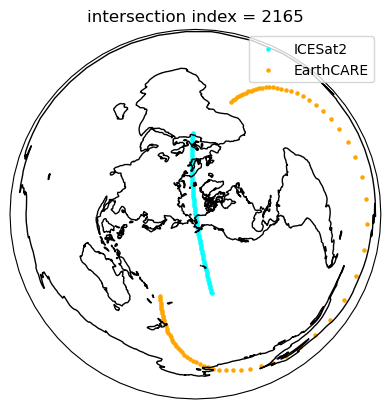

(np.float64(178.06470232005697), np.float64(44.67119659014741))


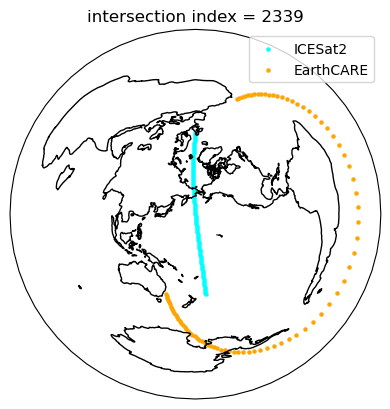

(np.float64(-5.907806778455048), np.float64(28.32276360954386))


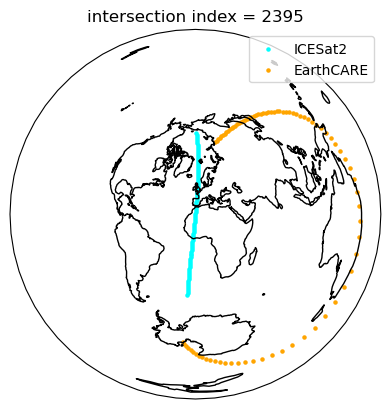

(np.float64(-23.22497151101503), np.float64(67.44031195959339))


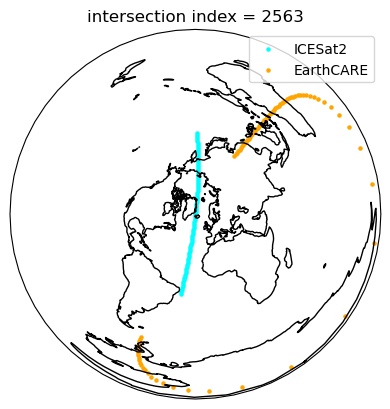

(np.float64(-41.712650307200335), np.float64(77.77798781398246))


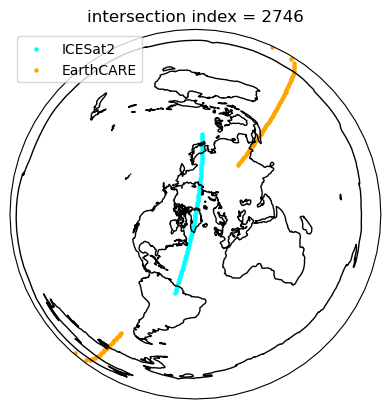

(np.float64(-102.5169392316679), np.float64(84.2757238936843))


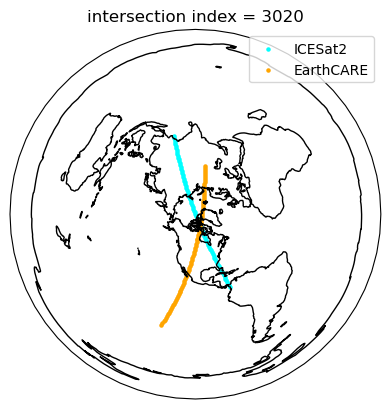

(np.float64(-123.39720112664354), np.float64(83.44986628922719))


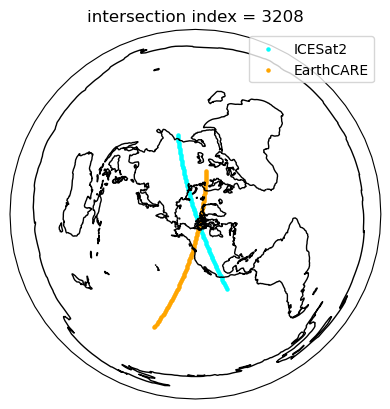

(np.float64(-141.54494643593225), np.float64(80.76558519748586))


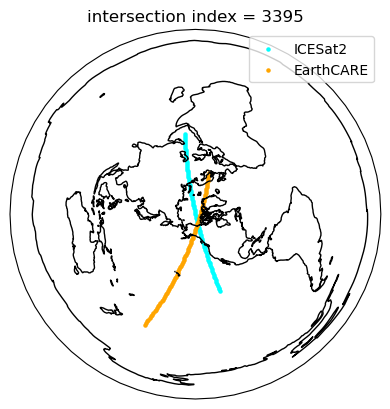

(np.float64(-160.6074853179924), np.float64(76.15736085883026))


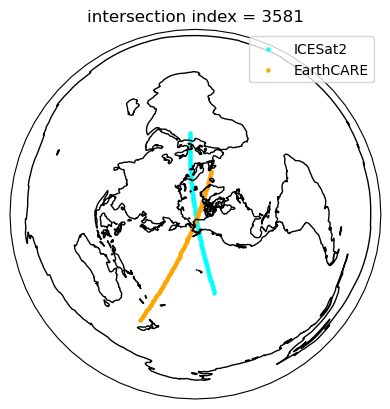

(np.float64(-112.62803122495096), np.float64(82.34644695517841))


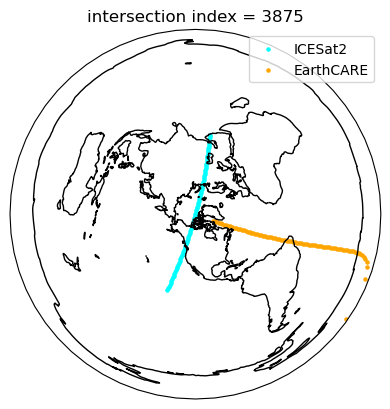

(np.float64(-140.37577164069603), np.float64(79.71109098559255))


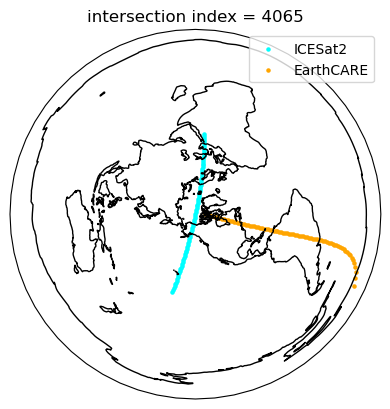

(np.float64(-172.03997119204948), np.float64(63.77760493920362))


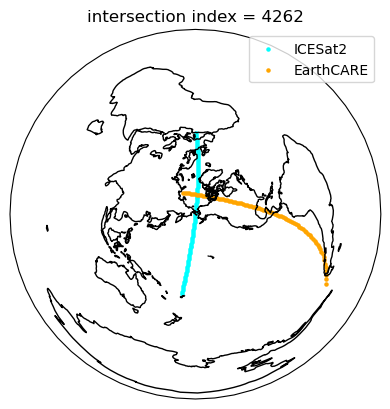

(np.float64(-21.885525366675186), np.float64(69.23841046035284))


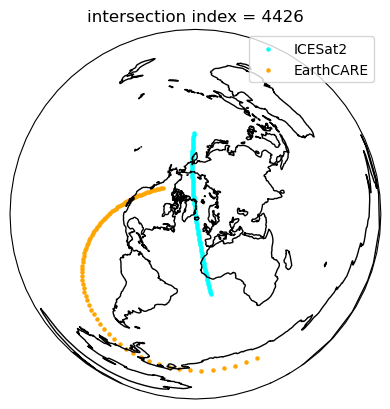

(np.float64(-54.21779165467049), np.float64(81.32715876873661))


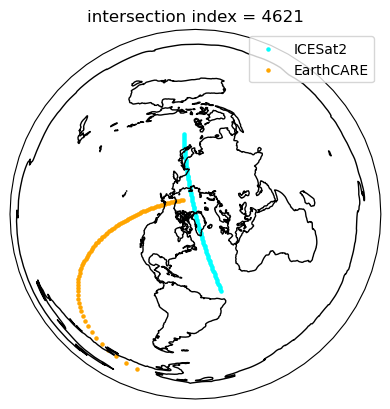

(np.float64(-83.9131162191234), np.float64(83.92788986665462))


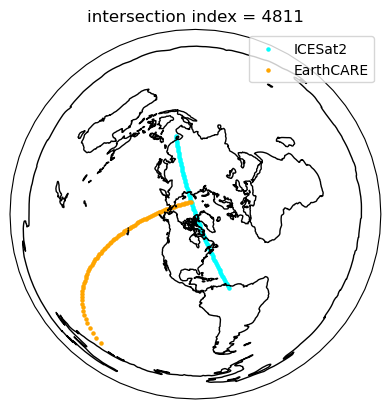

(np.float64(-101.17833908532465), np.float64(82.02416005444069))


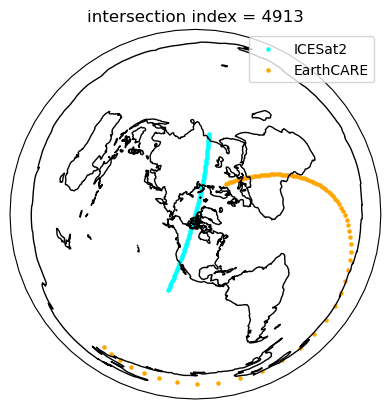

(np.float64(-126.51106537976274), np.float64(81.01729776794934))


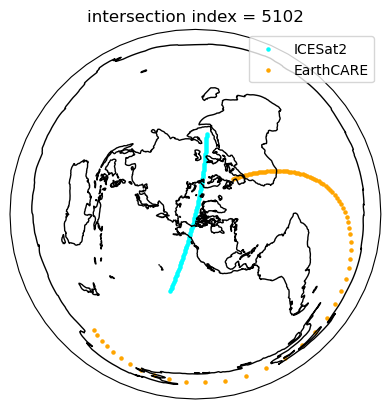

(np.float64(-154.9687236067758), np.float64(76.24821029282685))


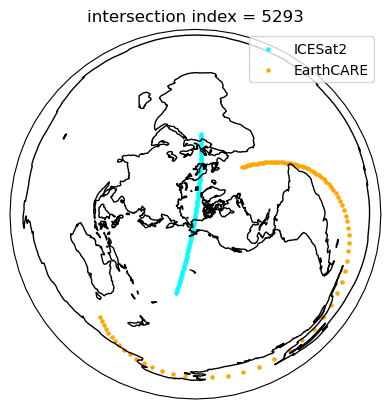

(np.float64(-0.27909560097363584), np.float64(3.3045175044290773))


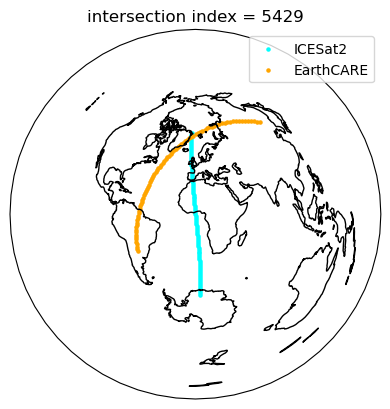

(np.float64(-38.86345294453582), np.float64(78.83911936536312))


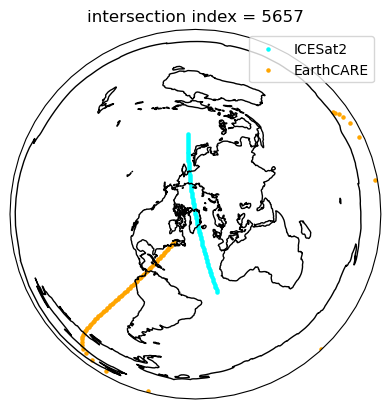

(np.float64(-70.54386881296537), np.float64(83.55085096416066))


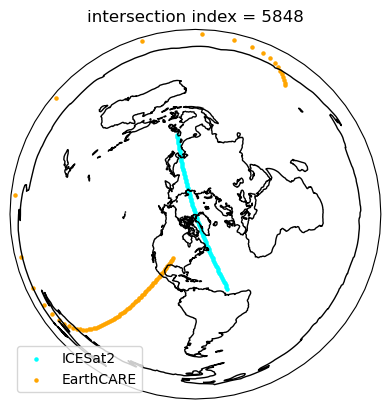

(np.float64(-97.58849721519977), np.float64(84.5299717902128))


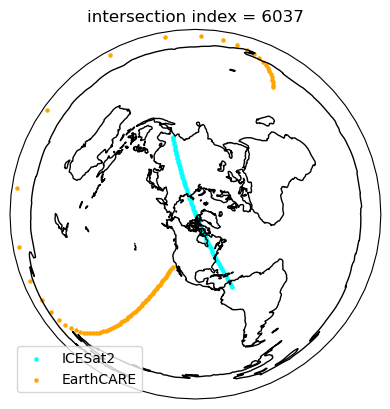

(np.float64(-74.89734347662828), np.float64(82.74622238095526))


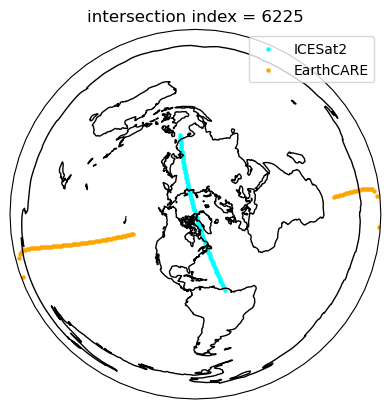

(np.float64(-100.54706336920593), np.float64(83.52202718037765))


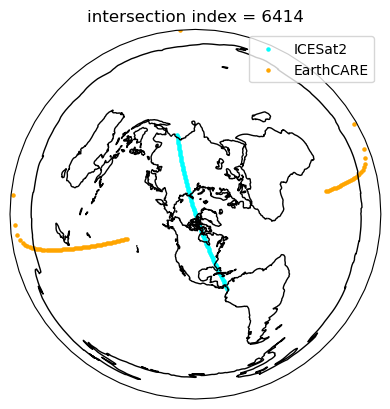

(np.float64(-121.5247417175758), np.float64(82.47519676074663))


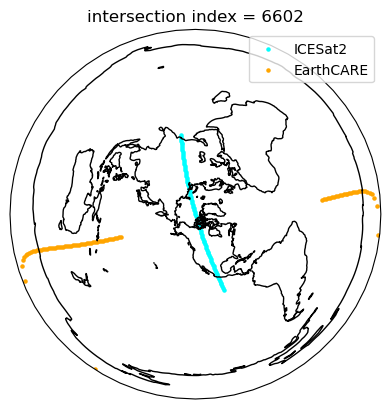

(np.float64(-143.13039289712566), np.float64(81.41752474367331))


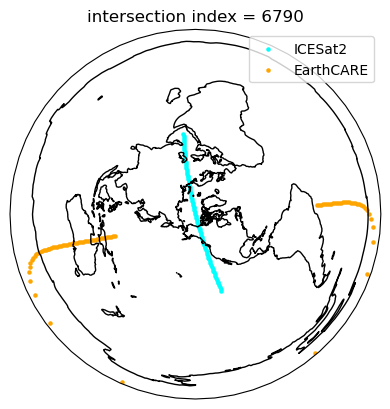

(np.float64(-160.29520509445518), np.float64(74.71836171722425))


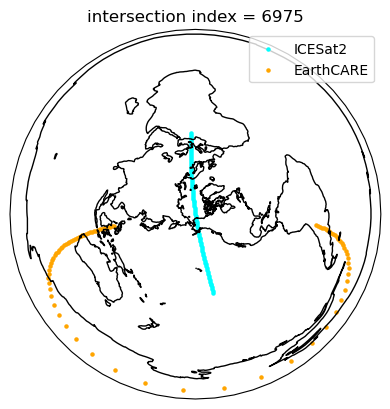

(np.float64(-178.08819748242323), np.float64(54.63742710702225))


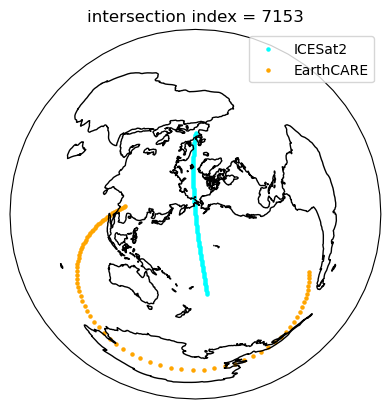

(np.float64(-2.2278337662585925), np.float64(12.535166543568069))


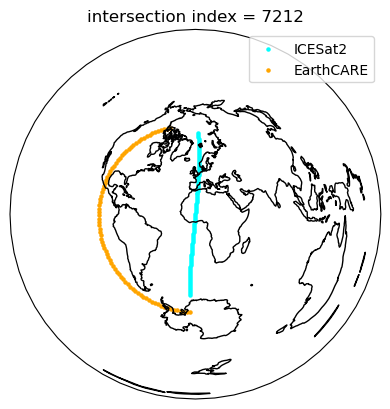

(np.float64(-18.972993640472513), np.float64(63.445219413562334))


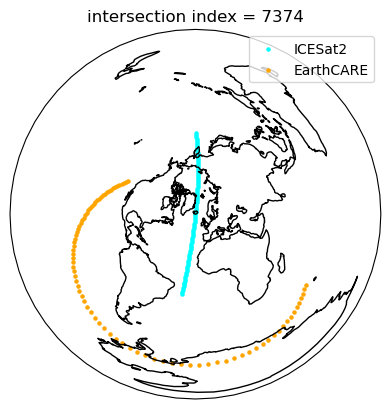

(np.float64(-37.79468539431664), np.float64(75.91290551523598))


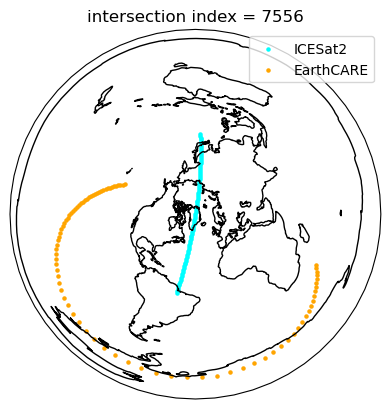

(np.float64(-56.74661321112125), np.float64(80.73765175774255))


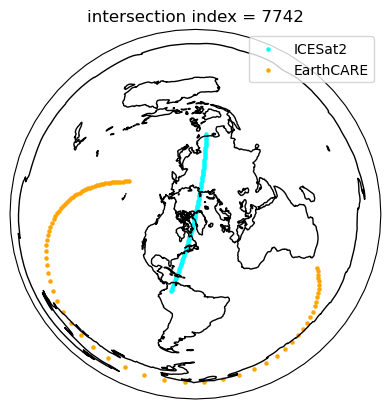

(np.float64(-78.64561100697642), np.float64(81.79782628348619))


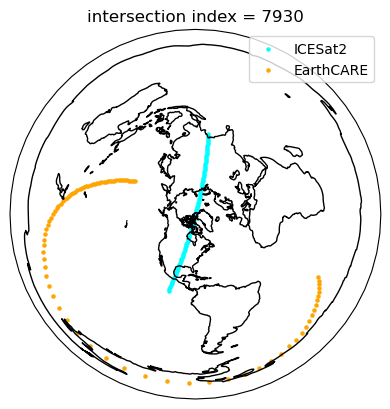

(np.float64(-73.95208138038365), np.float64(80.69227873448625))


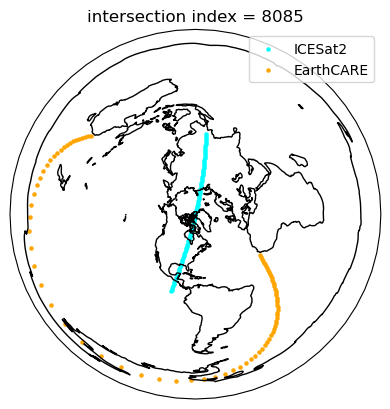

(np.float64(-95.83027241229475), np.float64(81.77465326815701))


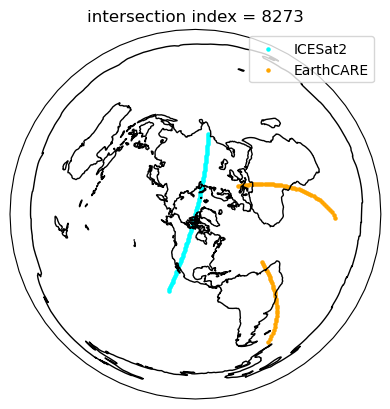

(np.float64(-120.73323786648734), np.float64(81.00331578688721))


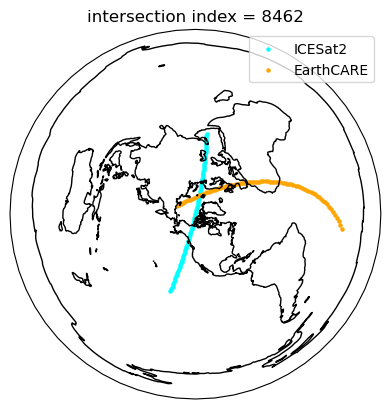

(np.float64(-147.49977328352196), np.float64(78.35717484853808))


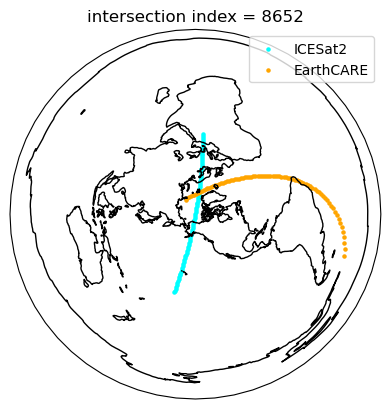

(np.float64(178.99769667521517), np.float64(45.22779049575212))


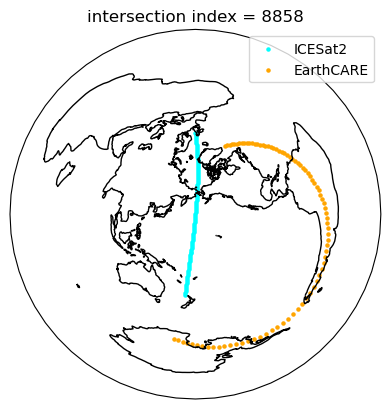

(np.float64(-29.813792519057934), np.float64(74.38195200573381))


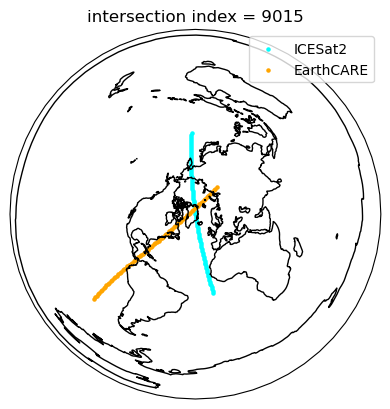

(np.float64(-62.45702381037016), np.float64(82.64237979142891))


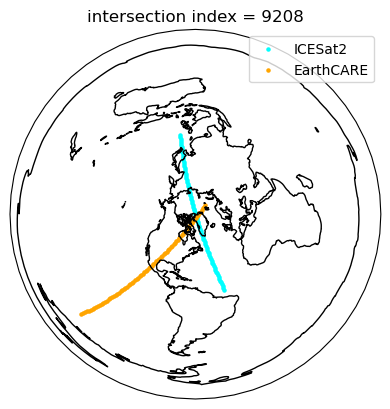

(np.float64(-88.00573219132241), np.float64(83.40396205967379))


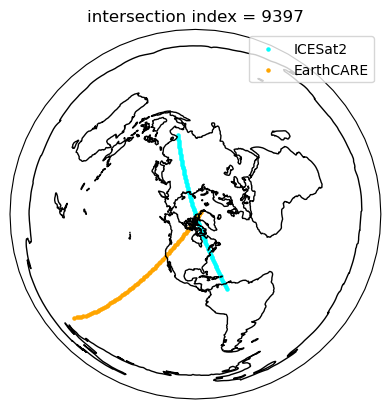

(np.float64(-87.20953059243769), np.float64(83.14407316491892))


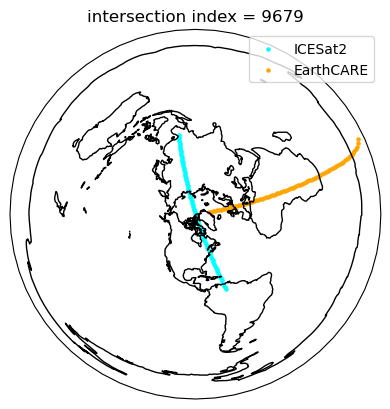

(np.float64(-113.75926699295196), np.float64(84.10784303988896))


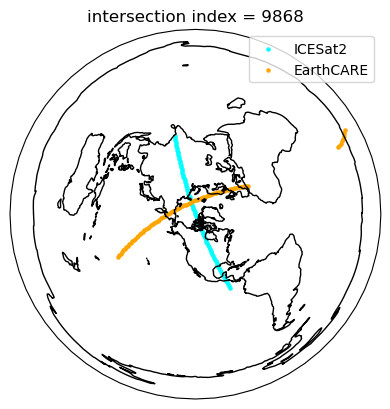

(np.float64(-134.74139365438967), np.float64(83.2647471907113))


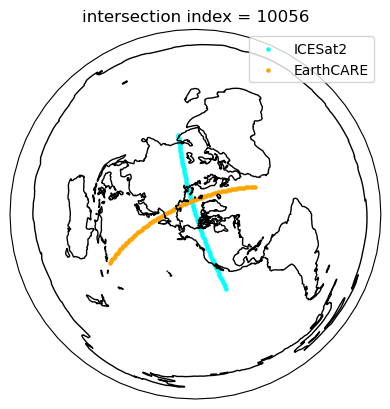

(np.float64(-150.93306008255612), np.float64(78.69246753597469))


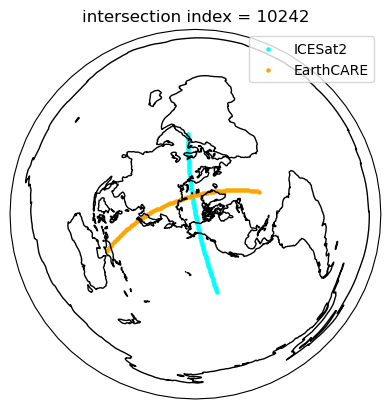

(np.float64(-169.52791235864981), np.float64(70.26027989045745))


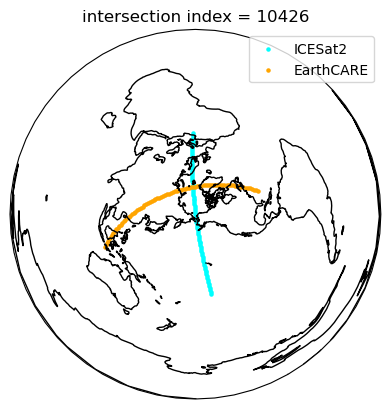

(np.float64(173.99586571350588), np.float64(29.293659454817934))


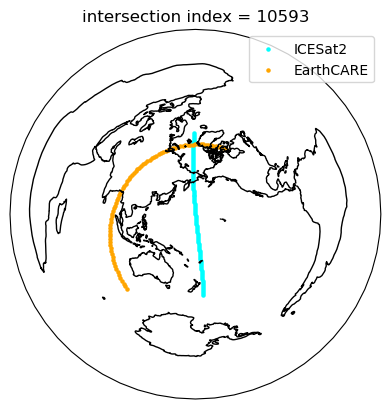

(np.float64(-9.995875609907047), np.float64(43.73060285673077))


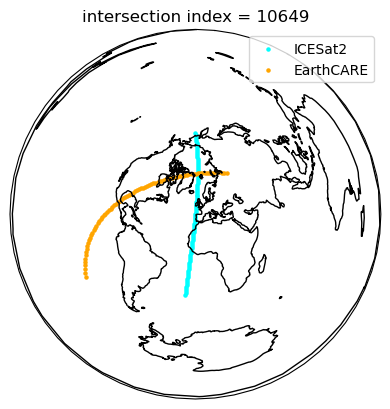

(np.float64(-27.79779845231889), np.float64(71.31087828283195))


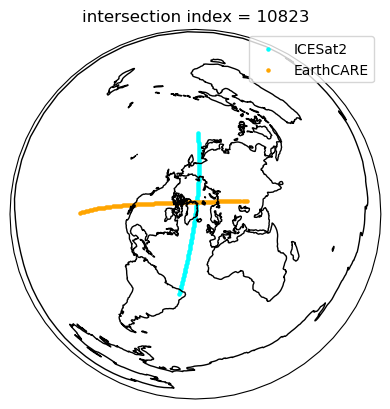

(np.float64(-47.57029457696609), np.float64(77.85778266883766))


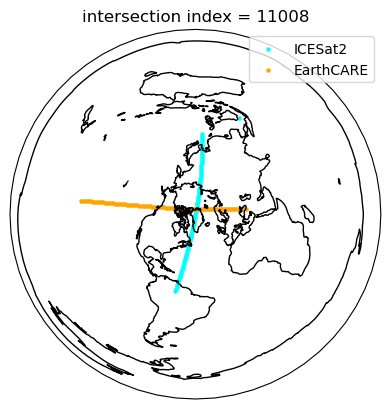

(np.float64(-110.42124134374478), np.float64(84.67799296806056))


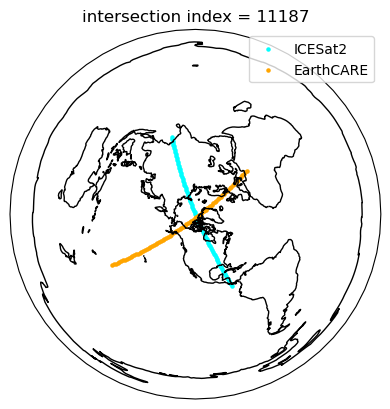

(np.float64(-130.24265201075352), np.float64(83.64391206629635))


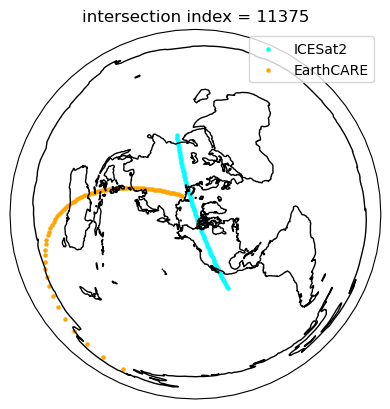

(np.float64(-147.7981700789289), np.float64(80.74358857086466))


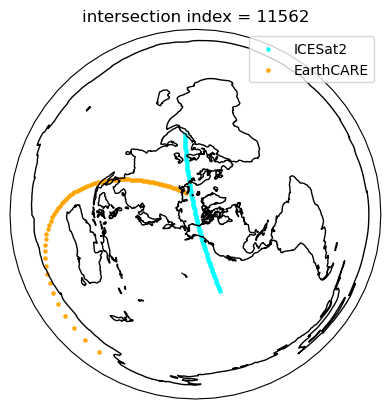

(np.float64(-164.72164129595745), np.float64(72.13365773362483))


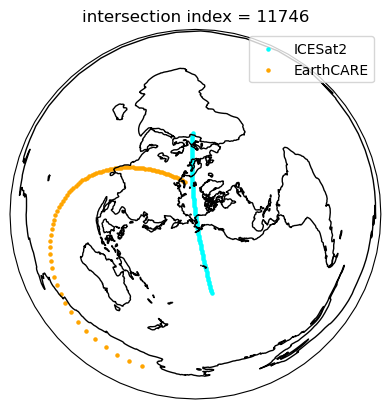

(np.float64(177.72411928218335), np.float64(44.39211391655423))


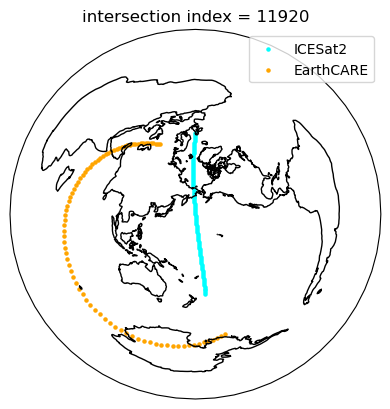

(np.float64(-6.0396631052708605), np.float64(30.553982550917805))


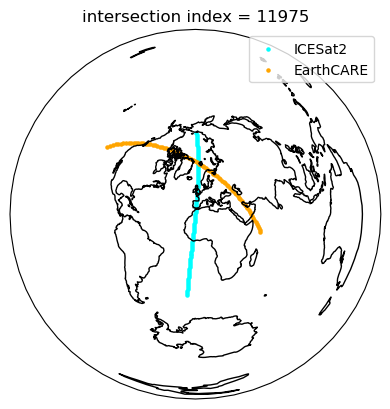

(np.float64(-23.4558069245718), np.float64(67.96926707398934))


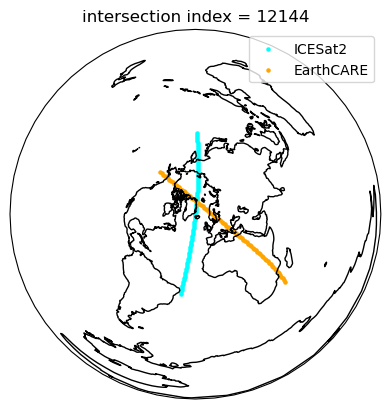

(np.float64(-43.017814857968396), np.float64(76.63495850659766))


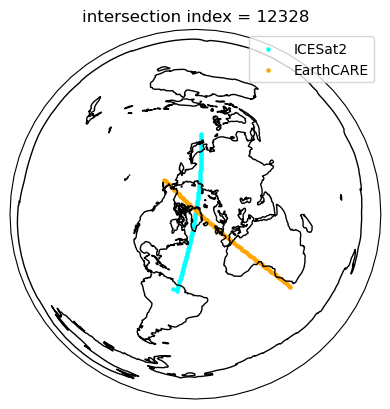

(np.float64(-81.36621349972187), np.float64(83.17590925255072))


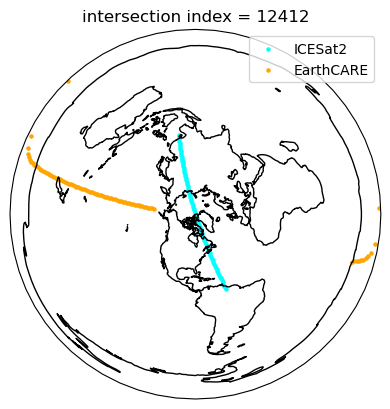

(np.float64(-107.96637854127151), np.float64(84.14539593303444))


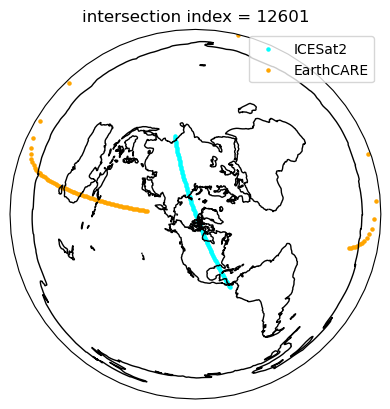

(np.float64(-128.93456845074644), np.float64(83.30909383315864))


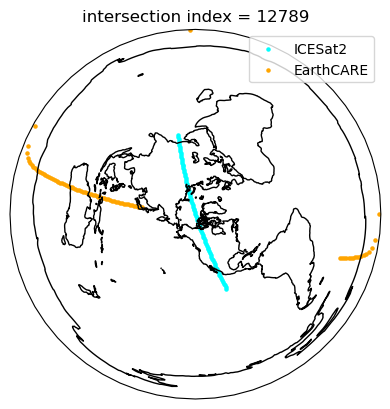

(np.float64(-62.35800897622714), np.float64(80.51807480376768))


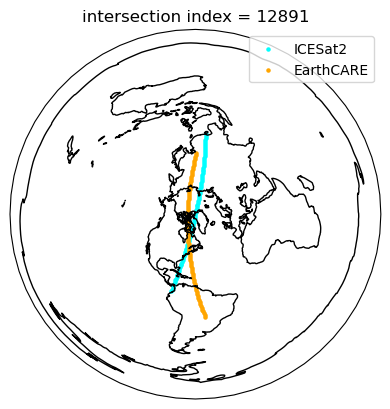

(np.float64(-84.66874208861711), np.float64(81.37565838397876))


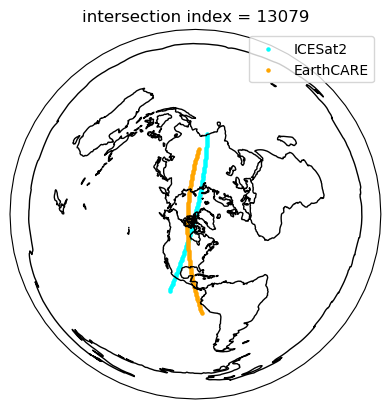

(np.float64(-106.71071525463066), np.float64(82.22788891266289))


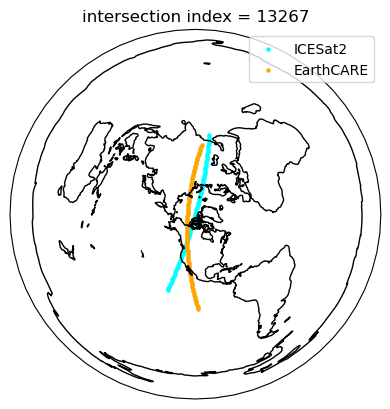

(np.float64(-132.11235051614057), np.float64(81.23156632939101))


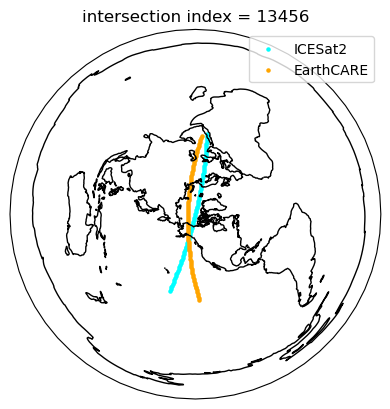

(np.float64(-162.89993569394463), np.float64(72.69599168715123))


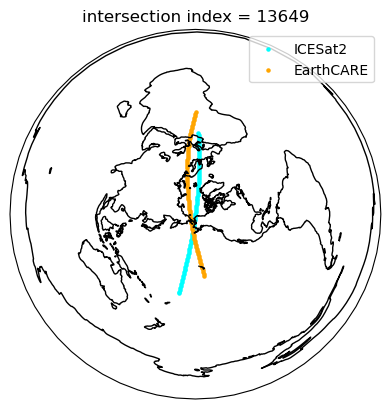

(np.float64(-11.975250965108392), np.float64(52.894525791236255))


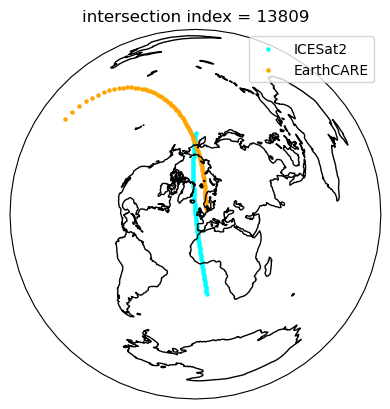

(np.float64(-46.70595341122664), np.float64(80.46525836992308))


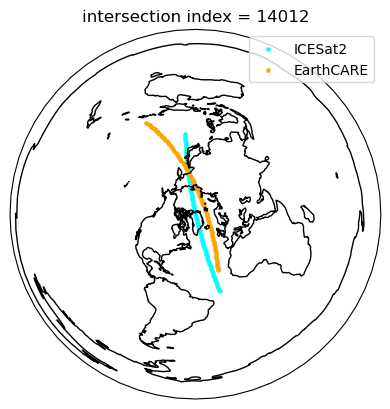

(np.float64(-75.78245139632537), np.float64(83.30524089711847))


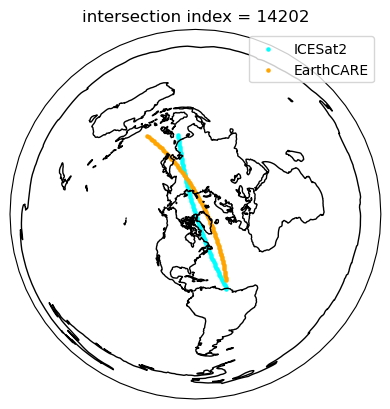

(np.float64(-177.78145921103751), np.float64(56.29198324493046))


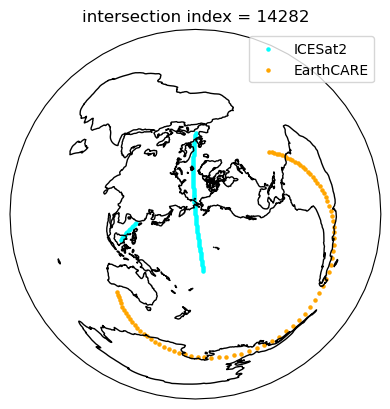

(np.float64(-1.8042998839292905), np.float64(10.849327324624204))


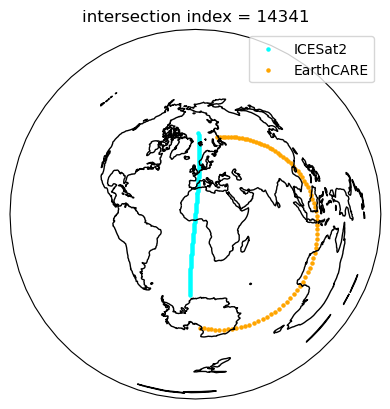

(np.float64(-18.362470582331216), np.float64(63.45703330653385))


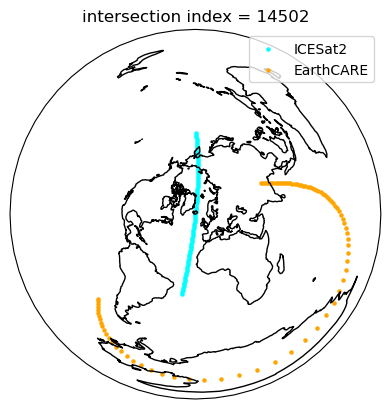

(np.float64(-37.30669608806471), np.float64(75.70928035087796))


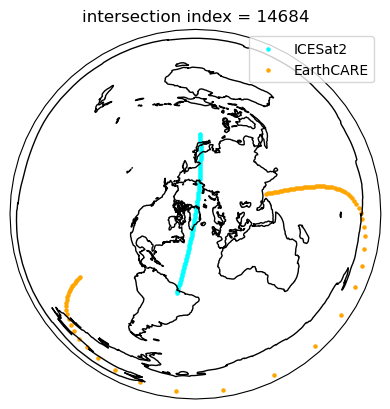

(np.float64(-56.6848069183637), np.float64(80.32391185716243))


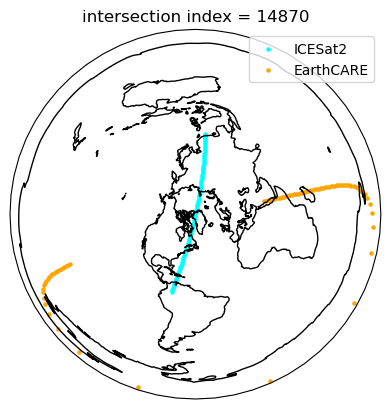

(np.float64(-79.05896514056757), np.float64(81.17415626890944))


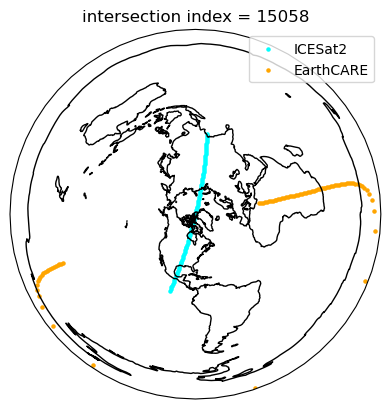

(np.float64(-118.26802023632939), np.float64(83.7209022627869))


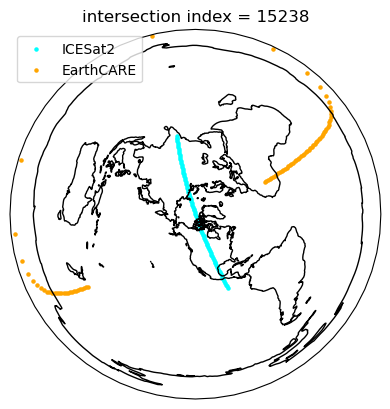

(np.float64(-139.04643120690338), np.float64(82.6556785456624))


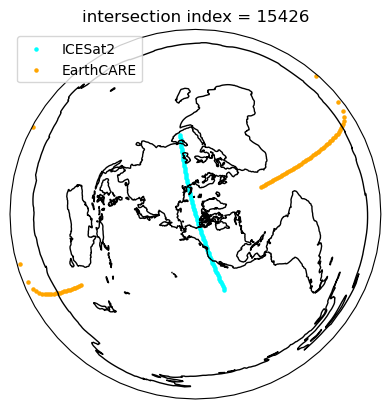

(np.float64(-155.98910879906094), np.float64(77.84676352426541))


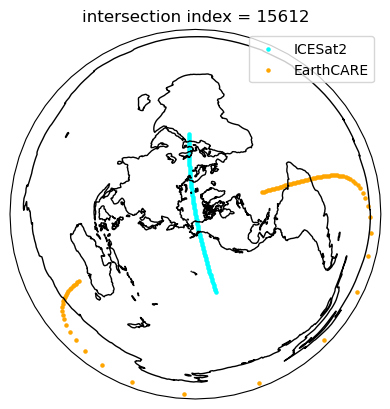

(np.float64(-173.36970315041776), np.float64(63.492560468789236))


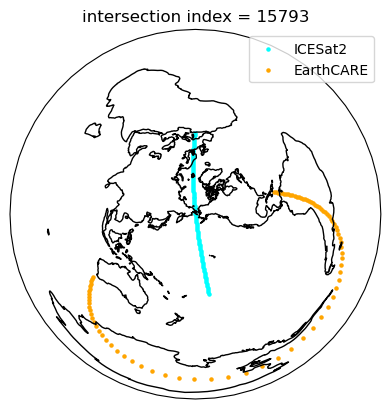

(np.float64(-14.25103144265246), np.float64(54.620759530413395))


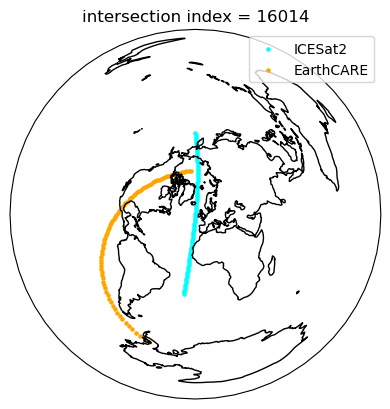

(np.float64(-32.03145302698053), np.float64(74.74388514598769))


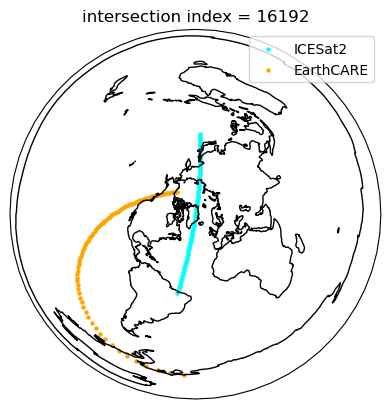

(np.float64(-51.72997274061178), np.float64(79.60395189895576))


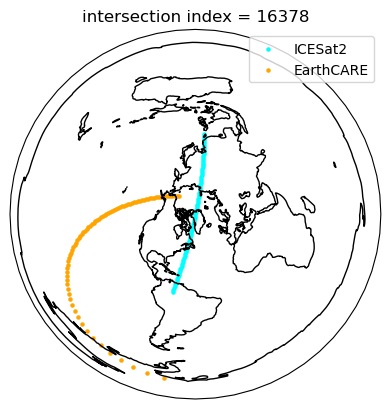

(np.float64(-114.02958135445407), np.float64(84.15422075818564))


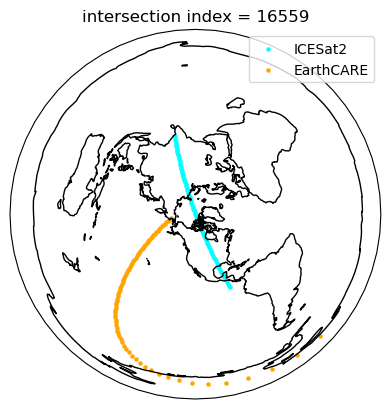

(np.float64(-134.4306003096048), np.float64(83.10277264493335))


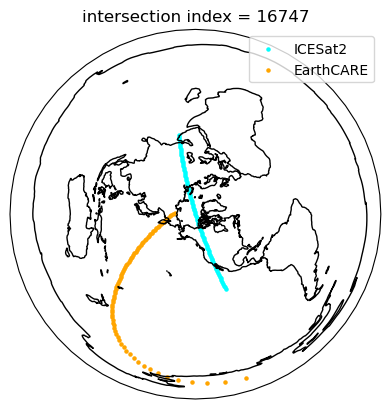

(np.float64(-150.70313920363773), np.float64(78.31228275017695))


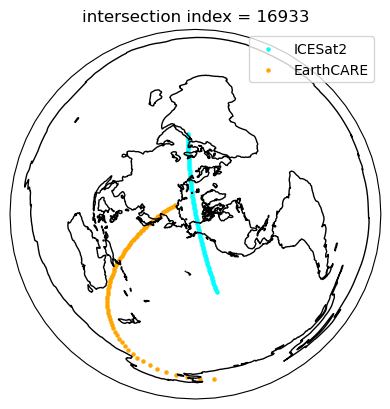

(np.float64(-169.45840164291172), np.float64(69.66300823351693))


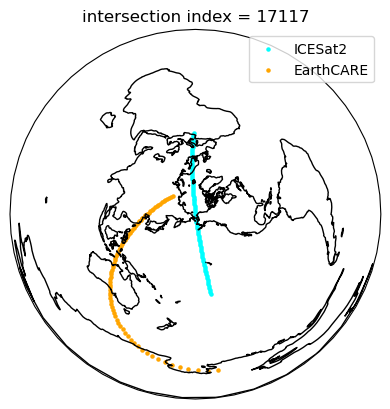

(np.float64(173.92293357833074), np.float64(28.507964474757735))


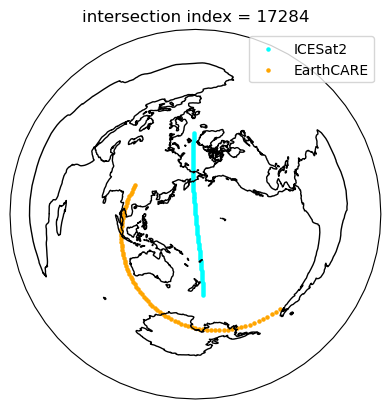

(np.float64(-10.048079722578892), np.float64(44.5696166928613))


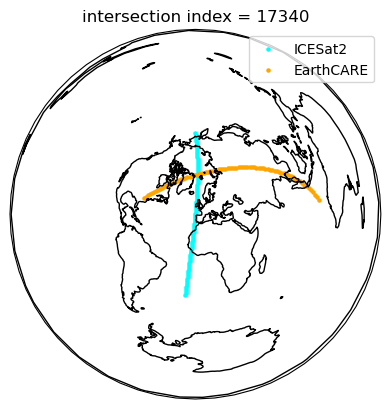

(np.float64(-27.5301419026954), np.float64(72.35848141444644))


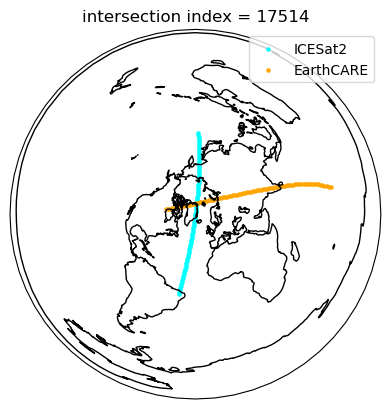

(np.float64(-46.56955719680439), np.float64(79.1091327945155))


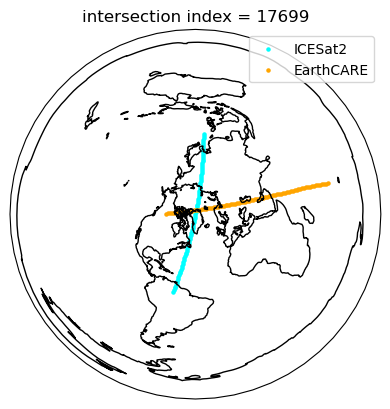

(np.float64(-65.99101939844545), np.float64(82.04844825449061))


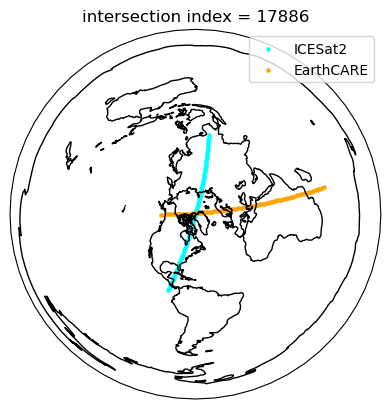

(np.float64(-90.98651133112003), np.float64(81.27176314881319))


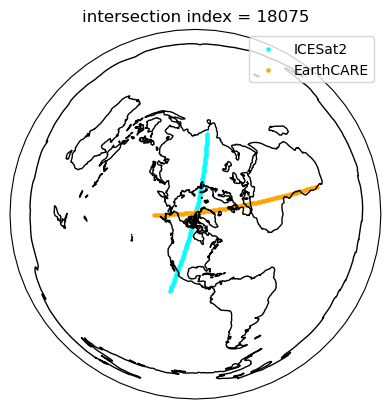

(np.float64(-61.34078262955389), np.float64(81.46086425172587))


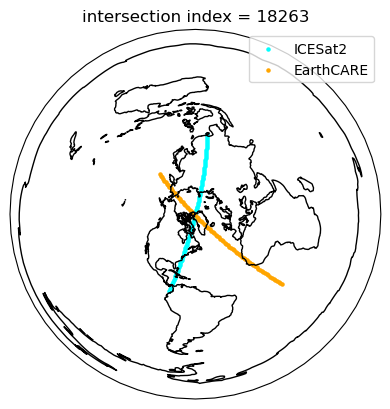

(np.float64(-82.91355334986963), np.float64(82.52388070036777))


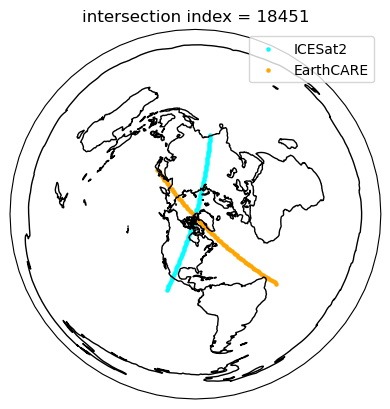

(np.float64(-108.08621761923865), np.float64(81.74312072895053))


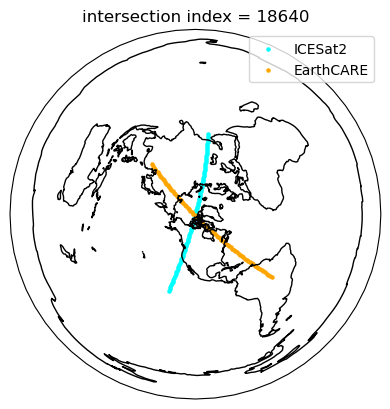

(np.float64(-133.00139621135585), np.float64(80.95714979754693))


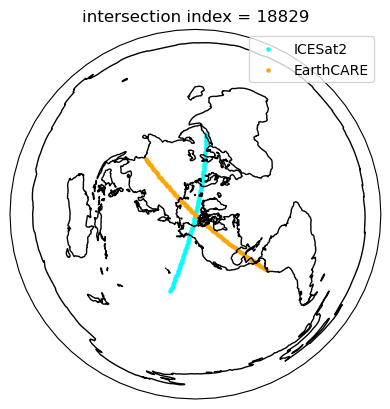

(np.float64(-163.40688949140176), np.float64(72.63493090611986))


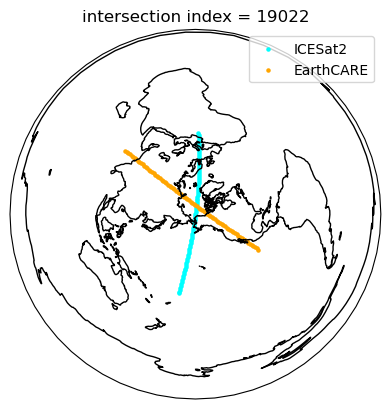

(np.float64(-12.762897594676273), np.float64(54.667205391289656))


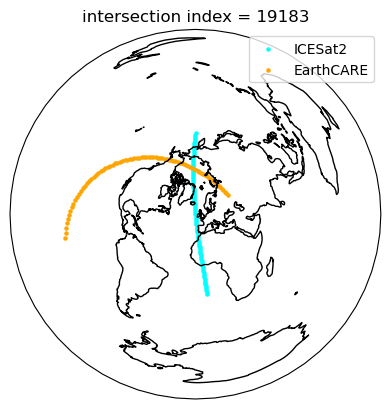

(np.float64(-46.74417962966449), np.float64(80.10409670242244))


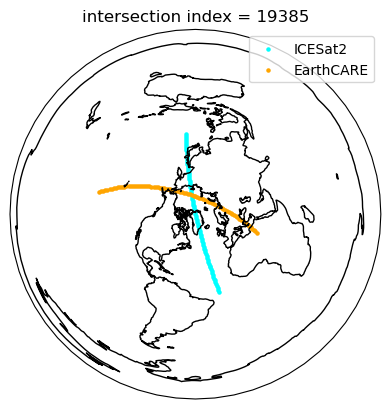

In [27]:
for slicei in intersection_indices:
    intersection_slice = slice(slicei, slicei + N)

    #proj_center = mean_spherical_pos(icesat_lon_lat[0], icesat_lon_lat[1])
    proj_center = ( icesat_lon_lat[0][slicei+N_halfwidth], icesat_lon_lat[1][slicei+N_halfwidth] )
    projection = ccrs.PlateCarree()
    projection = ccrs.Orthographic(central_longitude=proj_center[0], central_latitude=proj_center[1]) 
    projection = ccrs.AzimuthalEquidistant(central_longitude=proj_center[0], central_latitude=proj_center[1])
    #projection = ccrs.Stereographic(central_longitude=proj_center[0], central_latitude=proj_center[1])
    #projection = ccrs.Orthographic(central_longitude=proj_center[0], central_latitude=80) 
    transform = ccrs.PlateCarree()
    print(proj_center)

    fig, ax = plt.subplots(
        1,1,
        #figsize=(15,8),
        subplot_kw=dict(
            projection=projection
        )
    )

    #ax.scatter(lon_slice, lat_slice, s=10)
    ax.scatter(
        icesat_lon_lat[0][intersection_slice],
        icesat_lon_lat[1][intersection_slice],
        s=5,
        c="cyan",
        label="ICESat2",
        transform=transform
    )
    ax.scatter(
        earthcare_lon_lat[0][intersection_slice],
        earthcare_lon_lat[1][intersection_slice],
        s=5,
        c="orange",
        label="EarthCARE",
        transform=transform
    )
    ax.coastlines()
    ax.set_global()
    ax.legend()
    ax.set_title(f"intersection index = {slicei}")

    plt.show()